##FMP EDA and Feature Engineering

###Justin Parsons
###MSDS692 S8W1 2025

This notebook contains EDA and feature engineering on all of the data associated with the FMP API data calls. This includes economic score, social score, governance score, ESGScirem, historical employee counts, and current employee counts. Feature engineering for place names is also contained within this notebook, but is unrelated to the aformentioned FMP data.

*There are multiple hardcoded environment-dependent lines within this script, but they are easily identified and changed without breaking the code.*



Outcomes:

*   EDA on new features including histograms (2013-2023)  
*   Compare previous employee count data with newly retrieved data for completeness
*   Quick look at IQR of ESG data...other team members are working outlier problems
*   Compare historic vs "non-historic" employee count information
*   Nationality of reporting producers for ESG and employee count data
*   Covariance for selected features against scope 3 emission amount for each emission type



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import sys
import datetime
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [2]:
#link google drive and set path. Only necessary if using Google drive to store code and data.

drive.mount('/content/drive/')

#hardcoded for Justin Parsons' environment
sys.path.append('/content/drive/MyDrive/GHG/')
sys.path.append('/content/drive/MyDrive/GHG/Code/')
sys.path.append('/content/drive/MyDrive/GHG/Data/')

#path to data from API calls
path = "/content/drive/MyDrive/GHG/Data/"

Mounted at /content/drive/


Here I create dataframes using all of the data from my API calls. Of note, mm_df is the data currently being used, with possible exceptions, for our model.  



In [3]:
#Building dataframes from FMP CSV files and Mega Merged file.
#There is probably a better way to pull the most recent data based on timestamp which I'll work later
mm_df = pd.read_csv(path + "Mega_merged_all_real_values.csv") #mega merged file
esg_df = pd.read_csv(path + "ESG_data_20250216_022136.csv") #ESG data
ec_df = pd.read_csv(path + "EC_data_20250216_022136.csv") #employee count data
ec_hist_df = pd.read_csv(path + "EC_hist_data_20250216_022136.csv") #second hist employee count data pull

<ipython-input-3-a9cff1012609>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mm_df = pd.read_csv(path + "Mega_merged_all_real_values.csv") #mega merged file


In [4]:
mm_accounts = mm_df['account_name'].unique()
pd.DataFrame(mm_accounts, columns=['account_name']).to_csv('/content/drive/MyDrive/GHG/Data/mm_accounts.csv', index=False)

You will see below that not all of the dataframes have the same number of rows. ESG, for example, is tied to a single ticker (Symbol_1) so it was pulled only on unique tickers and only once.

## Employee Count Data##

In [5]:
mm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181156 entries, 0 to 181155
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    181156 non-null  int64  
 1   account_name                  181156 non-null  object 
 2   incorporated_country          181156 non-null  object 
 3   ticker                        117989 non-null  object 
 4   Evaluation_status             180307 non-null  object 
 5   Scope_3_emissions_type        181156 non-null  object 
 6   Scope_3_emissions_amount      181156 non-null  float64
 7   Symbol_1                      181156 non-null  object 
 8   Year                          181156 non-null  int64  
 9   Market_Cap                    115901 non-null  float64
 10  Employee_Count                23397 non-null   float64
 11  ebitda                        118470 non-null  float64
 12  Revenue                       118470 non-nul

Examine distribution of some features. Note this is not the best way as many are not displayed. Other group memebers are examining outliers and normalization and this is just  a sanity check.

In [6]:
mm_df.describe()

,account_id,Scope_3_emissions_amount,Year,Market_Cap,Employee_Count,ebitda,Revenue,grossProfit,netIncome,cashAndCashEquivalents,...,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD
count,1.811560e+05,1.811560e+05,181156.000000,1.159010e+05,2.339700e+04,1.184700e+05,1.184700e+05,1.184700e+05,1.184700e+05,1.184350e+05,...,1.166220e+05,1.166220e+05,1.165870e+05,1.165870e+05,1.165870e+05,1.165870e+05,1.165870e+05,1.165870e+05,1.165870e+05,1.165870e+05
mean,1.414151e+05,3.433412e+06,2019.402029,1.657642e+15,4.766602e+04,2.633005e+11,1.585992e+12,4.791358e+11,8.941202e+10,3.971887e+11,...,6.051487e+09,1.235744e+09,5.187228e+09,3.604949e+09,1.175354e+10,5.727666e+10,4.353627e+10,1.445493e+10,1.077381e+10,1.091297e+10
std,2.928111e+05,3.038475e+08,3.120940,1.367633e+17,1.938753e+05,2.537825e+12,1.050003e+13,3.769761e+12,1.515486e+12,3.473805e+12,...,2.000368e+10,3.920166e+09,2.786781e+10,2.831609e+10,6.575693e+10,2.009303e+11,1.757555e+11,7.796944e+10,3.131216e+10,3.578274e+10
min,2.600000e+01,0.000000e+00,2013.000000,6.458000e+01,0.000000e+00,-1.810998e+13,-2.795100e+10,-2.964573e+13,-9.039563e+13,-1.706996e+12,...,-3.558570e+12,-2.235500e+10,-1.953227e+10,-1.414534e+12,-6.990780e+11,0.000000e+00,0.000000e+00,-6.990780e+11,0.000000e+00,-1.807500e+10
25%,9.956000e+03,7.100000e+01,2017.000000,7.244848e+09,9.780000e+02,7.636000e+08,4.914000e+09,1.611770e+09,1.995000e+08,5.267000e+08,...,5.882304e+08,6.890562e+07,2.188800e+08,0.000000e+00,2.140838e+07,3.227040e+09,1.615740e+09,4.752000e+07,5.778000e+08,1.243608e+09
50%,1.984500e+04,3.583000e+03,2020.000000,3.343209e+10,1.203000e+04,3.757000e+09,2.160900e+10,7.965500e+09,1.394000e+09,3.019000e+09,...,1.706349e+09,3.057000e+08,7.041600e+08,1.097600e+07,2.450490e+08,9.768860e+09,5.409965e+09,3.507456e+08,2.422566e+09,3.447036e+09
75%,5.041800e+04,5.386449e+04,2022.000000,2.478086e+11,4.300000e+04,3.433446e+10,2.620540e+11,7.376175e+10,1.251800e+10,4.889500e+10,...,5.418790e+09,1.054900e+09,2.254733e+09,2.489200e+08,1.627560e+09,3.101756e+10,1.848141e+10,1.952147e+09,7.706664e+09,9.990547e+09
max,1.003410e+06,1.210286e+11,2023.000000,1.129325e+19,1.220000e+07,8.808453e+13,3.022314e+14,1.232355e+14,5.506006e+13,2.454981e+14,...,2.700460e+11,9.980300e+10,7.408340e+11,7.264082e+11,1.313035e+12,3.875393e+12,3.547515e+12,1.528885e+12,7.756765e+11,5.291813e+12


Here the original employee counts contained within the Mega Merged dataset's distribution is examined. This distribution is *after* the data was merged into the mega merged dataset so this tells us the distribution post-mergining onto each unique Symbol_1 with a representative employee count.

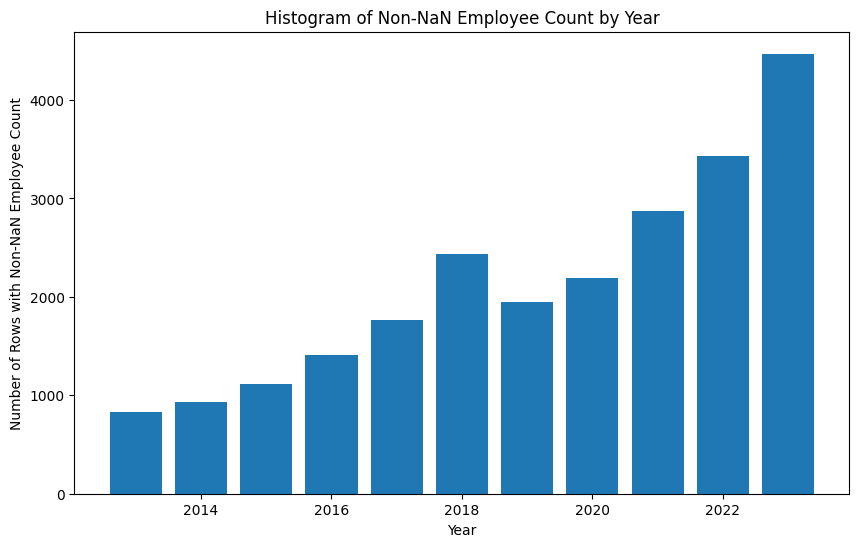

In [7]:
# group by year and count the number of rows with non-NaN values in the 'employeeCount' column
valid_ec_counts_by_year = mm_df.groupby('Year')['Employee_Count'].count()

# create histogram
plt.figure(figsize=(10, 6))
plt.bar(valid_ec_counts_by_year.index, valid_ec_counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Rows with Non-NaN Employee Count')
plt.title('Histogram of Non-NaN Employee Count by Year')
plt.show()

Checking to see how many unique Symbol_1 (companies) are represented within the original data. This is compared to the amount that have representative employee counts and ESG data.

In [8]:
#this the number of unique Symbol_1s
symbol_1_unique = mm_df['Symbol_1'].nunique()
print(f"Number of unique Symbol_1: {symbol_1_unique}")


Number of unique Symbol_1: 5324


In [9]:
#this displays the number of symbols with non-zero and non-NaN employee count values
mm_tickers_with_employee_count = mm_df[
    (mm_df['Employee_Count'] != 0) &
    (mm_df['Employee_Count'].notna())
]['Symbol_1'].nunique()

print(f"Number of unique Symbol_1 with non-zero and non-NaN employee counts: {mm_tickers_with_employee_count}")

Number of unique Symbol_1 with non-zero and non-NaN employee counts: 669


13% (669/5324) of the companies contained within the mega merged dataset have employee counts from the original data calls to the FMP database.

###Non-historic Employee Count###
ec_df contains data associated with Symbol_1 and employee counts without a specified year. This API call is separate from the "historic" API call which will pull data for each year.

In [10]:
ec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5324 entries, 0 to 5323
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol_1        5324 non-null   object 
 1   periodOfReport  760 non-null    object 
 2   employeeCount   760 non-null    float64
dtypes: float64(1), object(2)
memory usage: 124.9+ KB


In [11]:
ec_df.describe()

,employeeCount
count,7.600000e+02
mean,4.129896e+04
std,1.217185e+05
min,0.000000e+00
25%,2.619000e+03
50%,1.149000e+04
75%,3.432950e+04
max,2.100000e+06


In [12]:

ec_df_not_nan = ec_df[ec_df['employeeCount'].notna()]
display(ec_df_not_nan.sample(10))

,Symbol_1,periodOfReport,employeeCount
3634,EXR,2023-12-31,7618.0
1588,NWS,2024-06-30,23900.0
771,PM,2024-12-31,83100.0
1193,GWW,2023-12-31,26000.0
2503,WFRD,2024-12-31,19000.0
2484,TNL,2023-12-31,19000.0
801,REE,2023-12-31,244.0
4848,BAMI,2023-12-31,0.0
495,IR,2023-12-31,18000.0
2635,PYPL,2024-12-31,24400.0


In [13]:
#add year column
ec_df['Year'] = pd.to_datetime(ec_df['periodOfReport'], errors='coerce', format="%Y-%m-%d").dt.year.astype('Int64')


In [14]:
ec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5324 entries, 0 to 5323
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol_1        5324 non-null   object 
 1   periodOfReport  760 non-null    object 
 2   employeeCount   760 non-null    float64
 3   Year            760 non-null    Int64  
dtypes: Int64(1), float64(1), object(2)
memory usage: 171.7+ KB


In [15]:
ec_df.sample(10)

,Symbol_1,periodOfReport,employeeCount,Year
1718,NOD.OL,NaN,NaN,<NA>
5067,CERT,2023-12-31,1400.0,2023
4573,WDP.BR,NaN,NaN,<NA>
116,BBAS3.SA,NaN,NaN,<NA>
5132,7199.T,NaN,NaN,<NA>
693,9432.T,NaN,NaN,<NA>
754,IGTE,NaN,NaN,<NA>
3022,0127101D,NaN,NaN,<NA>
16,AGN.AS,NaN,NaN,<NA>
1166,ABI.BR,NaN,NaN,<NA>


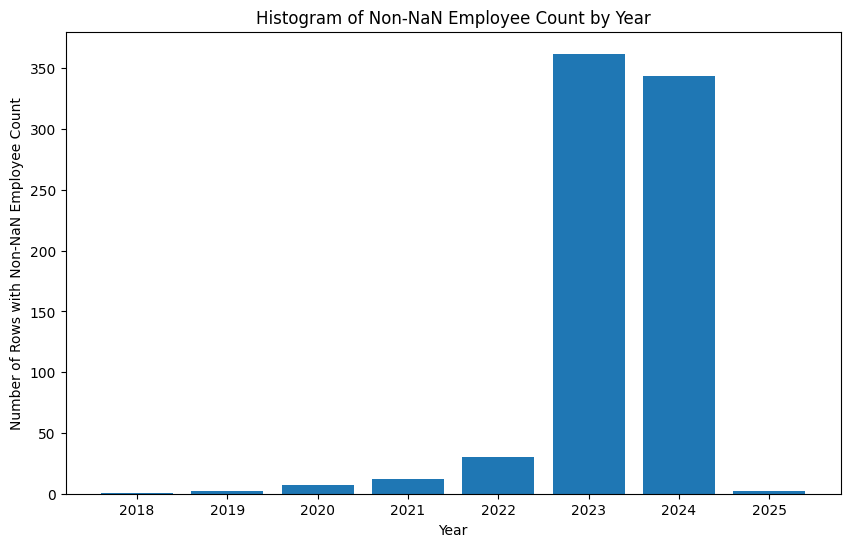

In [16]:
# group by year and count the number of rows with non-NaN values in the 'employeeCount' column
valid_counts_by_year = ec_df.groupby('Year')['employeeCount'].count()

# create histogram
plt.figure(figsize=(10, 6))
plt.bar(valid_counts_by_year.index, valid_counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Rows with Non-NaN Employee Count')
plt.title('Histogram of Non-NaN Employee Count by Year')
plt.show()

This shows that the "non-historic" API call seems to either pull the most recent reported employee count or does so on some other latency criteria.

In [17]:
#this displays the number of symbols with non-zero and non-NaN employee count values
ec_tickers_with_employee_count = ec_df[
    (ec_df['employeeCount'] != 0) &
    (ec_df['employeeCount'].notna())
]['Symbol_1'].nunique()

print(f"Number of unique Symbol_1 with non-zero and non-NaN employee counts: {ec_tickers_with_employee_count}")

Number of unique Symbol_1 with non-zero and non-NaN employee counts: 704


The more recent pull had a slightly higher number of reported values. 13.2% of the companies within the original mega merged dataframe contain employee counts for this API call.

###Historic Employee Count Data Pull###

Below is an examination of the data acquired using FMP's "historic employee count" API calls.

In [18]:
ec_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Symbol_1       6584 non-null   object
 1   year           6584 non-null   int64 
 2   employeeCount  6584 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.4+ KB


In [19]:
ec_hist_df.describe()

,year,employeeCount
count,6584.000000,6.584000e+03
mean,2018.222357,3.986207e+04
std,3.124352,1.195421e+05
min,2013.000000,0.000000e+00
25%,2016.000000,2.939500e+03
50%,2018.000000,1.030000e+04
75%,2021.000000,3.500000e+04
max,2023.000000,2.300000e+06


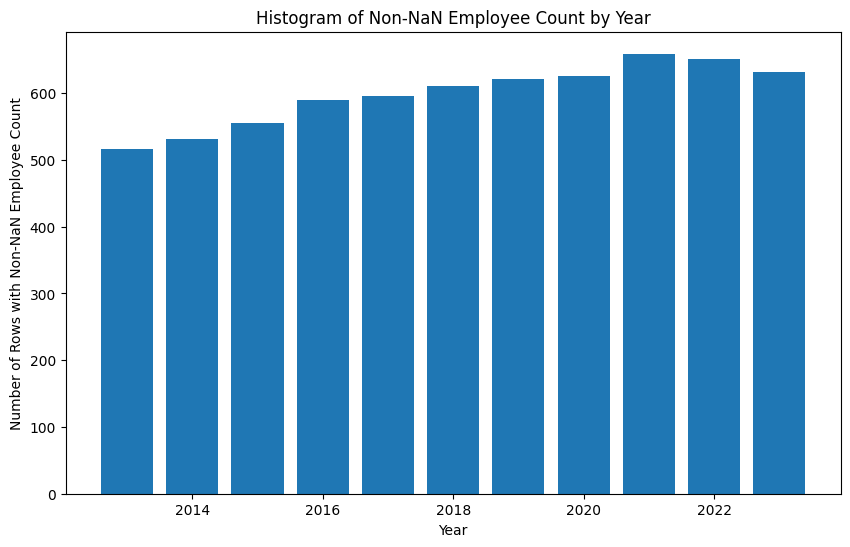

In [20]:
# group by year and count the number of rows with non-NaN values in the 'employeeCount' column
valid_hist_counts_by_year = ec_hist_df.groupby('year')['employeeCount'].count()

# create histogram
plt.figure(figsize=(10, 6))
plt.bar(valid_hist_counts_by_year.index, valid_hist_counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Rows with Non-NaN Employee Count')
plt.title('Histogram of Non-NaN Employee Count by Year')
plt.show()

In [21]:
ec_hist_df = ec_hist_df.rename(columns={"year": "Year"})

In [22]:
ec_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Symbol_1       6584 non-null   object
 1   Year           6584 non-null   int64 
 2   employeeCount  6584 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.4+ KB


In [23]:
#this displays the number of symbols with non-zero and non-NaN employee count values
ec_hist_tickers_with_employee_count = ec_hist_df[
    (ec_hist_df['employeeCount'] != 0) &
    (ec_hist_df['employeeCount'].notna())
]['Symbol_1'].nunique()

print(f"Number of unique Symbol_1 with non-zero and non-NaN employee counts: {ec_hist_tickers_with_employee_count}")

Number of unique Symbol_1 with non-zero and non-NaN employee counts: 656


While there are more individual entries obtained through the historic API call this is due to multiple years being reported for some companies. 12.3% of the companies within mega merged are represented with historic employee counts.

###ESG Data###
Examination of ESG API call which returns economic, social, governance, and ESGScore data for whatever years have been reported.

In [25]:
#this displays the number of symbols with non-zero and non-NaN ESG values
esg_tickers_with_employee_count = esg_df[
    (esg_df['ESGScore'] != 0) &
    (esg_df['ESGScore'].notna())
]['Symbol_1'].nunique()

print(f"Number of unique Symbol_1 with non-zero and non-NaN ESG score: {esg_tickers_with_employee_count}")

Number of unique Symbol_1 with non-zero and non-NaN ESG score: 885


16.6% of companies within the mega merged dataset have associated ESG data.

In [ ]:
esg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5324 entries, 0 to 5323
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol_1            5324 non-null   object 
 1   date                885 non-null    object 
 2   environmentalScore  885 non-null    float64
 3   socialScore         885 non-null    float64
 4   governanceScore     885 non-null    float64
 5   ESGScore            885 non-null    float64
dtypes: float64(4), object(2)
memory usage: 249.7+ KB


In [ ]:
esg_df.describe()

,environmentalScore,socialScore,governanceScore,ESGScore
count,885.000000,885.000000,885.000000,885.000000
mean,61.937548,64.019390,66.106441,64.021107
std,12.469099,9.909818,7.855943,8.465379
min,0.280000,12.440000,20.320000,21.430000
25%,54.770000,58.400000,61.970000,59.480000
50%,62.080000,64.390000,66.230000,64.100000
75%,69.340000,69.950000,71.210000,69.150000
max,99.760000,98.750000,91.900000,93.200000


In [ ]:
#head and sample functions do not do a good job at showing there are actual entries for ESG values since only 7% of the total rows contain entries
esg_df_not_nan = esg_df[esg_df['ESGScore'].notna()]
display(esg_df_not_nan.sample(10))

,Symbol_1,date,environmentalScore,socialScore,governanceScore,ESGScore
3079,COLM,2024-09-30,74.64,94.08,79.25,82.66
1053,VER,2020-09-30,58.26,70.71,78.47,69.15
4811,PTC,2024-12-31,51.21,58.16,75.63,61.67
1458,NWL,2024-12-31,53.00,64.44,64.17,60.54
358,FCAU,2019-12-31,66.00,71.06,70.45,69.17
3189,INFN,2024-09-28,56.63,53.65,54.59,54.96
5066,SEDG,2024-09-30,71.85,67.69,65.87,68.47
196,CELG,2019-09-30,57.91,66.23,65.54,63.23
520,VIAV,2024-12-28,24.90,12.44,65.39,34.24
3619,ULTA,2024-11-02,44.87,63.61,71.50,59.99


This is a quick look at the distribution and IQR-based outlier outlook of the ESG data. This will be used to inform team members working outlier treatment on ESG data.

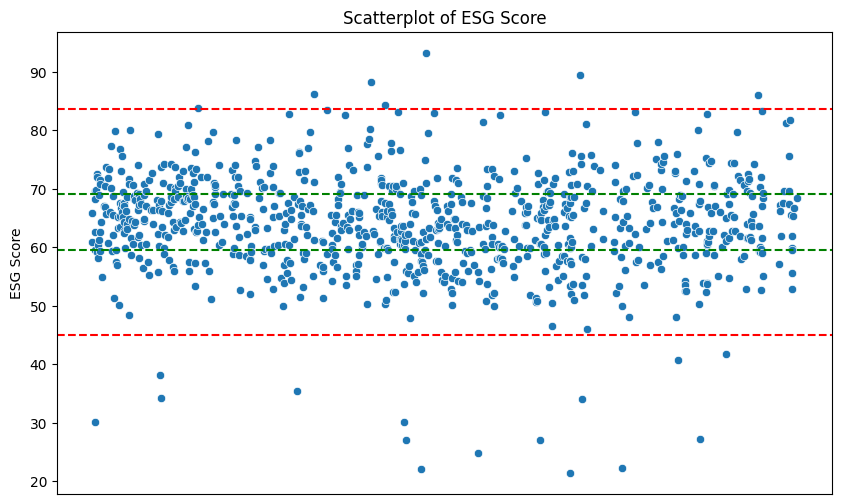

In [ ]:
#esg score per Symbol_1 without xlabel

# first quartile (Q1) and third quartile (Q3)
Q1 = esg_df['ESGScore'].quantile(0.25)
Q3 = esg_df['ESGScore'].quantile(0.75)

# Cinterquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


plt.figure(figsize=(10, 6))
sns.scatterplot(x='Symbol_1', y='ESGScore', data=esg_df)

plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
plt.axhline(y=Q1, color='g', linestyle='--', label='Q1')
plt.axhline(y=Q3, color='g', linestyle='--', label='Q3')

plt.xticks([])
plt.xlabel('')
plt.ylabel('ESG Score')
plt.title('Scatterplot of ESG Score')
plt.show()


In [ ]:
#add year column
esg_df['Year'] = pd.to_datetime(esg_df['date'], errors='coerce', format="%Y-%m-%d").dt.year.astype('Int64')

In [ ]:
esg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5324 entries, 0 to 5323
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol_1            5324 non-null   object 
 1   date                885 non-null    object 
 2   environmentalScore  885 non-null    float64
 3   socialScore         885 non-null    float64
 4   governanceScore     885 non-null    float64
 5   ESGScore            885 non-null    float64
 6   Year                885 non-null    Int64  
dtypes: Int64(1), float64(4), object(2)
memory usage: 296.5+ KB


Merge all data into the mega_merged dataframe after dropping old employee count. ESG and EC data is merged on symbol and year. It's the most recent data.


In [ ]:
# merge esg_df into mm_df
mm_esg_df = pd.merge(mm_df, esg_df[['Symbol_1', 'environmentalScore', 'socialScore', 'governanceScore', 'ESGScore']],
                   on=['Symbol_1'], how='left')

# merge ec_df into mm_df
df = pd.merge(mm_esg_df, ec_hist_df[['Symbol_1', 'Year', 'employeeCount']],
                   on=['Symbol_1', 'Year'], how='left')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181326 entries, 0 to 181325
Data columns (total 47 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    181326 non-null  int64  
 1   account_name                  181326 non-null  object 
 2   incorporated_country          181326 non-null  object 
 3   ticker                        118117 non-null  object 
 4   Evaluation_status             180477 non-null  object 
 5   Scope_3_emissions_type        181326 non-null  object 
 6   Scope_3_emissions_amount      181326 non-null  float64
 7   Symbol_1                      181326 non-null  object 
 8   Year                          181326 non-null  int64  
 9   Market_Cap                    116071 non-null  float64
 10  Employee_Count                23567 non-null   float64
 11  ebitda                        118640 non-null  float64
 12  Revenue                       118640 non-nul

##Continue EDA##



*   How do new/old employee count pulls compare after merging on year and symbol?
*   How is each country of incorporation represented with the new ESG and EC data?




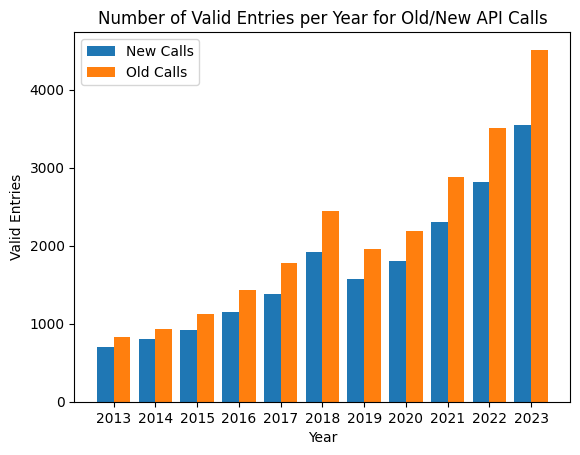

In [ ]:

X = mm_df['Year'].unique()
new_counts_by_year = df.groupby('Year')['employeeCount'].count()
og_counts_by_year = df.groupby('Year')['Employee_Count'].count()

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, new_counts_by_year, 0.4, label = 'New Calls')
plt.bar(X_axis + 0.2, og_counts_by_year, 0.4, label = 'Old Calls')

plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("Valid Entries")
plt.title("Number of Valid Entries per Year for Old/New API Calls")
plt.legend()
plt.show()

The historic employee count call was re-run many times with consistent inconsistancy compared to the original API call data. Based on the constance of the call methods used it is assumed this is related to server side issues related to call limiting at 300 per minute.  

The following cells examine what countries are represented within the data. Due to the small percentage of companies with reported ESG and employee count data the team's hypothesis that it was focused on US traded companies.

In [ ]:
#what countries are contained within the ESG data
mm_esg_counts = df[
    (df['ESGScore'] != 0) &
    (df['ESGScore'].notna())
]['incorporated_country'].unique()

print(f"Countries with reported ESGScores {mm_esg_counts}")

Countries with reported ESGScores ['USA' 'United Kingdom' 'Singapore' 'Austria' 'Italy' 'Ireland' 'Spain'
 'Switzerland' 'Guernsey' 'Peru' 'Canada' 'France' 'Israel' 'Poland'
 'Philippines' 'Thailand' 'Australia'
 'United Kingdom of Great Britain and Northern Ireland' 'Germany'
 'Netherlands' 'Colombia' 'Russian Federation'
 'China, Hong Kong Special Administrative Region' 'China' 'Cayman Islands'
 'Sweden' 'India' 'Jersey' 'Brazil' 'Mexico' 'Denmark' 'Luxembourg'
 'Japan' 'Argentina' 'Bermuda' 'Belgium' 'United Arab Emirates'
 'Marshall Islands' 'Taiwan']


incorporated_country
Argentina                              21
Australia                              74
Austria                               158
Bangladesh                              0
Belarus                                 0
                                     ... 
Venezuela                               0
Venezuela (Bolivarian Republic of)      0
Viet Nam                                0
Vietnam                                 0
Zimbabwe                                0
Name: ESGScore, Length: 113, dtype: int64


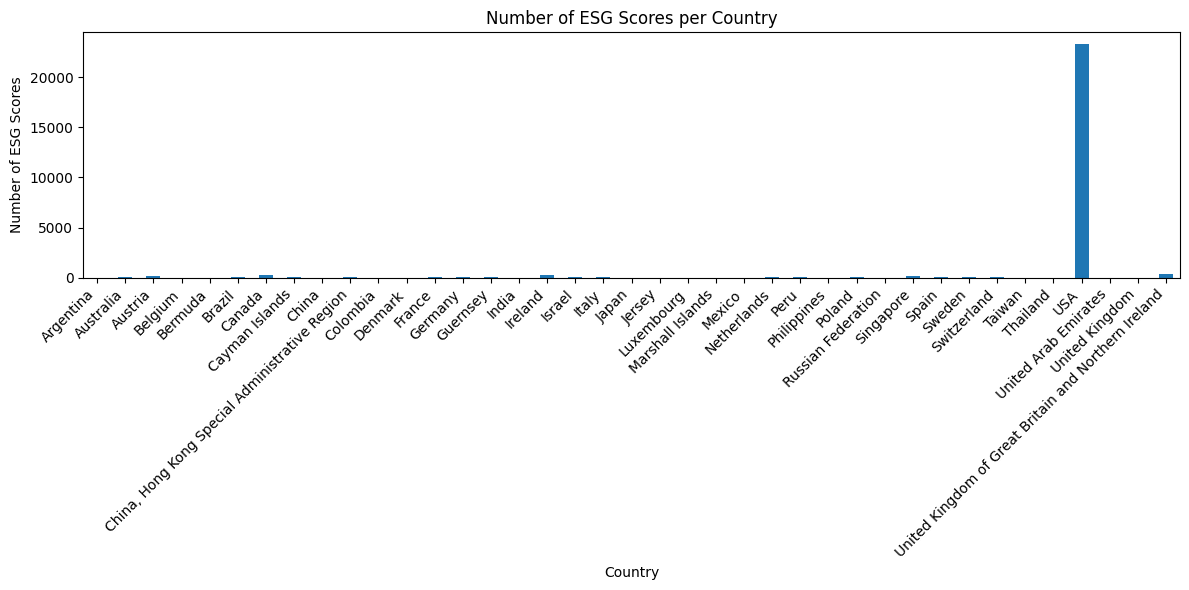

In [ ]:

# Count the occurrences of each country with non-zero ESG scores
country_esg_counts = df[df['ESGScore'] != 0].groupby('incorporated_country')['ESGScore'].count()
print(country_esg_counts)

# Filter out countries with zero counts
country_esg_counts = country_esg_counts[country_esg_counts > 0]

# Create the bar chart
plt.figure(num=1, figsize=(12, 6))
country_esg_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of ESG Scores')
plt.title('Number of ESG Scores per Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() #prevent overlap

# save plot
plt.savefig('country_esg_counts.png')
plt.show()


In [ ]:
mm_histEC_counts = df[
    (df['employeeCount'] != 0) &
    (df['employeeCount'].notna())
]['incorporated_country'].unique()

print(f"Countries with reported employee counts {mm_histEC_counts}")

Countries with reported employee counts ['USA' 'Austria' 'Singapore' 'Ireland' 'Switzerland' 'Guernsey'
 'United Kingdom' 'Canada' 'France' 'Israel' 'Poland' 'Philippines'
 'Thailand' 'United Kingdom of Great Britain and Northern Ireland'
 'Germany' 'Netherlands' 'Russian Federation' 'Australia' 'Bermuda'
 'China, Hong Kong Special Administrative Region' 'China' 'Sweden' 'India'
 'Jersey' 'Brazil' 'Denmark' 'Luxembourg' 'Spain' 'Japan' 'Argentina'
 'Marshall Islands' 'Peru' 'Colombia']


incorporated_country
Argentina                              21
Australia                              39
Austria                               111
Bangladesh                              0
Belarus                                 0
                                     ... 
Venezuela                               0
Venezuela (Bolivarian Republic of)      0
Viet Nam                                0
Vietnam                                 0
Zimbabwe                                0
Name: employeeCount, Length: 113, dtype: int64


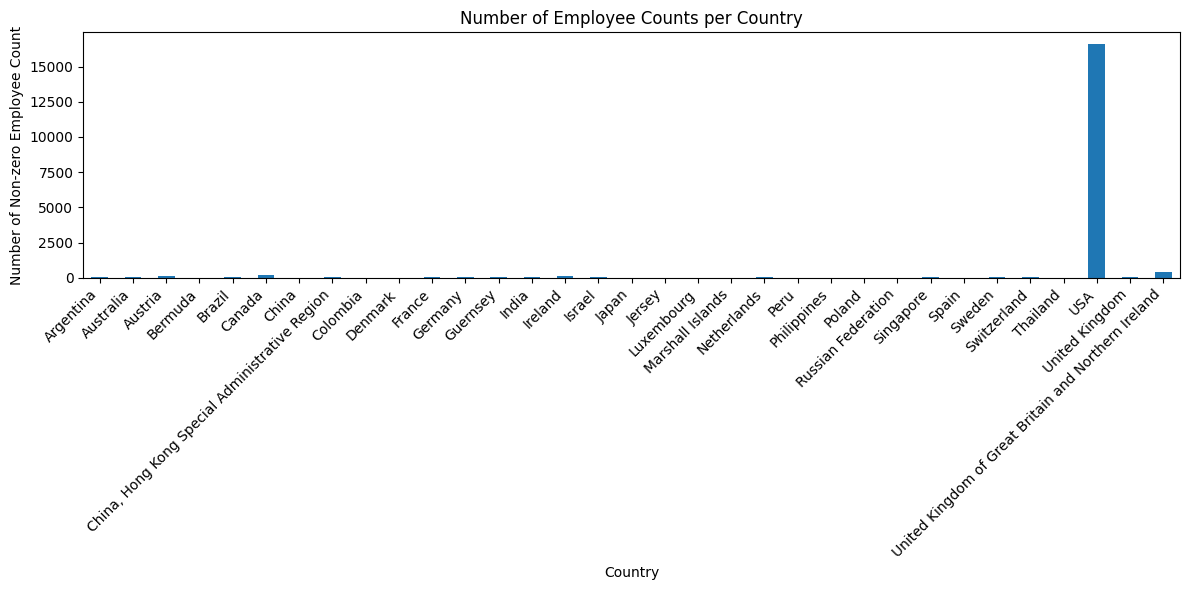

In [ ]:
# Count the occurrences of each country with non-zero ESG scores
country_EC_counts = df[df['employeeCount'] != 0].groupby('incorporated_country')['employeeCount'].count()
print(country_EC_counts)
# Filter out countries with zero counts
country_EC_counts = country_EC_counts[country_EC_counts > 0]

# Create the bar chart
plt.figure(num=2, figsize=(12, 6))
country_EC_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Non-zero Employee Count')
plt.title('Number of Employee Counts per Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() #prevent overlap

# save plot
plt.savefig('country_EC_counts.png')
plt.show()

The analysis above shows that, indeed it is mostly US companies with some others that are represented within the FMP data. Further analysis needs to be done in order to determine if these non-US companies are traded on US stock markets.

Here I add a random normal and random uniform feature to the dataframe for comparison.

In [ ]:
df['random_uniform'] = np.random.rand(len(df)) # uniform dist
df['random_normal'] = np.random.randn(len(df)) # normal dist

In [ ]:
#taking a look at dummy features to verify distributions
df.describe()

,account_id,Scope_3_emissions_amount,Year,Market_Cap,Employee_Count,ebitda,Revenue,grossProfit,netIncome,cashAndCashEquivalents,...,totalInvestments_USD,totalDebt_USD,totalEquity_USD,environmentalScore,socialScore,governanceScore,ESGScore,employeeCount,random_uniform,random_normal
count,1.813260e+05,1.813260e+05,181326.000000,1.160710e+05,2.356700e+04,1.186400e+05,1.186400e+05,1.186400e+05,1.186400e+05,1.186050e+05,...,1.167570e+05,1.167570e+05,1.167570e+05,25753.000000,25753.000000,25753.000000,25753.000000,1.892200e+04,181326.000000,181326.000000
mean,1.413595e+05,3.438165e+06,2019.403439,1.655214e+15,4.761637e+04,2.629286e+11,1.583742e+12,4.784610e+11,8.928782e+10,3.966239e+11,...,1.443490e+10,1.076880e+10,1.091219e+10,63.724171,64.126442,66.713122,64.854626,6.408170e+04,0.499445,0.006546
std,2.927552e+05,3.037214e+08,3.120711,1.366631e+17,1.932298e+05,2.536026e+12,1.049268e+13,3.767101e+12,1.514404e+12,3.471347e+12,...,7.791449e+10,3.129664e+10,3.576528e+10,11.218613,8.932906,7.422440,7.639067,1.803099e+05,0.288610,1.000484
min,2.600000e+01,0.000000e+00,2013.000000,6.458000e+01,0.000000e+00,-1.810998e+13,-2.795100e+10,-2.964573e+13,-9.039563e+13,-1.706996e+12,...,-6.990780e+11,0.000000e+00,-1.807500e+10,0.280000,12.440000,20.320000,21.430000,0.000000e+00,0.000014,-4.521146
25%,9.956000e+03,7.168875e+01,2017.000000,7.232966e+09,9.505000e+02,7.613300e+08,4.909658e+09,1.610700e+09,1.995000e+08,5.245000e+08,...,4.748800e+07,5.780000e+08,1.243816e+09,56.630000,58.870000,62.170000,60.290000,7.300000e+03,0.250275,-0.669973
50%,1.984500e+04,3.597000e+03,2020.000000,3.337026e+10,1.200000e+04,3.748000e+09,2.152000e+10,7.915000e+09,1.390422e+09,3.005645e+09,...,3.499000e+08,2.422579e+09,3.446675e+09,63.660000,64.530000,66.860000,65.220000,1.980000e+04,0.498670,0.006995
75%,5.031475e+04,5.397975e+04,2022.000000,2.474420e+11,4.370000e+04,3.431487e+10,2.611560e+11,7.322800e+10,1.251500e+10,4.879178e+10,...,1.942291e+09,7.702560e+09,9.986000e+09,71.110000,69.620000,71.740000,69.650000,6.076700e+04,0.748426,0.681326
max,1.003410e+06,1.210286e+11,2023.000000,1.129325e+19,1.220000e+07,8.808453e+13,3.022314e+14,1.232355e+14,5.506006e+13,2.454981e+14,...,1.528885e+12,7.756765e+11,5.291813e+12,99.760000,98.750000,91.900000,93.200000,2.300000e+06,0.999998,4.467491


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181326 entries, 0 to 181325
Data columns (total 49 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    181326 non-null  int64  
 1   account_name                  181326 non-null  object 
 2   incorporated_country          181326 non-null  object 
 3   ticker                        118117 non-null  object 
 4   Evaluation_status             180477 non-null  object 
 5   Scope_3_emissions_type        181326 non-null  object 
 6   Scope_3_emissions_amount      181326 non-null  float64
 7   Symbol_1                      181326 non-null  object 
 8   Year                          181326 non-null  int64  
 9   Market_Cap                    116071 non-null  float64
 10  Employee_Count                23567 non-null   float64
 11  ebitda                        118640 non-null  float64
 12  Revenue                       118640 non-nul

Building a dataframe of total scope 3 emissions per symbol_1 for covariance matrix

This outputs a file with the FMP data merged into the mega merged data. It's commented out here and I've just renamed the dataframe for simplicity

In [ ]:
#save dataframe with esg, ec, and dummy features
#input_path = "/content/drive/MyDrive/GHG/Data/"
#output_path = "/content/drive/MyDrive/GHG/Data/"

#filenames
#timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#mm_fmp_file_name = f'mm_fmp_data_{timestamp}.csv'
#mm_fmp_filtered_name = f'mm_fmp_filtered_{timestamp}.csv'

#path
#mm_fmp_output_file_path_and_name = output_path + mm_fmp_file_name
#mm_fmp_filtered_file_path_and_name = output_path + mm_fmp_filtered_name

#df.to_csv(mm_fmp_output_file_path_and_name, index=False)

#df_filtered.to_csv(mm_fmp_filtered_file_path_and_name, index=False)

##Feature Engineering

Distributing emissions types to independent dataframes. Many countries are represented by different place names. Futhermore countries are grouped into regions for later analysis.

In [ ]:
# Replace 0 with 'unclassified' in 'sector', 'industry', and 'activity' columns
df['Primary sector'] = df['Primary sector'].fillna('Unclassified')
df['Primary industry'] = df['Primary industry'].fillna('Unclassified')
df['Primary activity'] = df['Primary activity'].fillna('Unclassified')
df['Primary sector'] = df['Primary sector'].replace('0', 'unclassified')
df['Primary industry'] = df['Primary industry'].replace('0', 'unclassified')
df['Primary activity'] = df['Primary activity'].replace('0', 'Unclassified')
df['Employee_Count'] = df['Employee_Count'].replace('0', 'unclassified')

#Drop any companies with revenues and number of employees equal to 0
df = df[df['Revenue'] > 0]

# Clean incoporated country column
df['incorporated_country'] = df['incorporated_country'].replace('Ã…land Islands', 'Finland')
df['incorporated_country'] = df['incorporated_country'].replace('China, Hong Kong Special Administrative Region', 'China')
df['incorporated_country'] = df['incorporated_country'].replace('China, Macao Special Administrative Region', 'China')
df['incorporated_country'] = df['incorporated_country'].replace('Czechia', 'Czech Republic')
df['incorporated_country'] = df['incorporated_country'].replace('Faroe Islands', 'Denmark')
df['incorporated_country'] = df['incorporated_country'].replace('Guernsey', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('Hong Kong', 'China')
df['incorporated_country'] = df['incorporated_country'].replace('Isle of Man', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('Jersey', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('Norfolk Island', 'Australia')
df['incorporated_country'] = df['incorporated_country'].replace('Republic of Korea', 'South Korea')
df['incorporated_country'] = df['incorporated_country'].replace('Russian Federation', 'Russia')
df['incorporated_country'] = df['incorporated_country'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('United States Minor Outlying Islands', 'USA')
df['incorporated_country'] = df['incorporated_country'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
df['incorporated_country'] = df['incorporated_country'].replace('Viet Nam', 'Vietnam')

<ipython-input-102-21eb30feb2c8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['incorporated_country'] = df['incorporated_country'].replace('Ã…land Islands', 'Finland')
<ipython-input-102-21eb30feb2c8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['incorporated_country'] = df['incorporated_country'].replace('China, Hong Kong Special Administrative Region', 'China')
<ipython-input-102-21eb30feb2c8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118530 entries, 0 to 181282
Data columns (total 49 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    118530 non-null  int64  
 1   account_name                  118530 non-null  object 
 2   incorporated_country          118530 non-null  object 
 3   ticker                        96566 non-null   object 
 4   Evaluation_status             118102 non-null  object 
 5   Scope_3_emissions_type        118530 non-null  object 
 6   Scope_3_emissions_amount      118530 non-null  float64
 7   Symbol_1                      118530 non-null  object 
 8   Year                          118530 non-null  int64  
 9   Market_Cap                    114473 non-null  float64
 10  Employee_Count                23512 non-null   float64
 11  ebitda                        118530 non-null  float64
 12  Revenue                       118530 non-null  fl

In [ ]:
#Map countries to new region column
country_to_region = {
    'United Kingdom': 'Europe',
    'USA': 'North America',
    'Italy': 'Europe',
    'India': 'Asia',
    'Spain': 'Europe',
    'France': 'Europe',
    'Switzerland': 'Europe',
    'Netehrlands': 'Europe',
    'Japan': 'Asia',
    'South Africa': 'Africa',
    'Canada': 'North America',
    'New Zealand': 'Oceania',
    'Turkey': 'Asia',
    'Germany': 'Europe',
    'Australia': 'Oceania',
    'Luxembourg': 'Europe',
    'Taiwan': 'Asia',
    'Norway': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Brazil': 'South America',
    'Portugal': 'Europe',
    'China': 'Asia',
    'Singapore': 'Asia',
    'South Korea': 'Asia',
    'Russia': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'Belgium': 'Europe',
    'Finland': 'Europe',
    'Poland': 'Europe',
    'Malaysia': 'Asia',
    'Mexico': 'North America',
    'Thailand': 'Asia',
    'Vietnam': 'Asia',
    'Philippines': 'Asia',
    'Indonesia': 'Asia',
    'Greece': 'Europe',
    'Chile': 'South America',
    'Argentina': 'South America',
    'Peru': 'South America',
    'Colombia': 'South America',
    'Ecuador': 'South America',
    'Uruguay': 'South America',
    'Paraguay': 'South America',
    'Bolivia': 'South America',
    'Venezuela': 'South America',
    'Panama': 'North America',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'El Salvador': 'North America',
    'Nicaragua': 'North America',
    'Guatemala': 'North America',
    'Belize': 'North America',
    'Hungary': 'Europe',
    'Israel': 'Asia',
    'Cyprus': 'Europe',
    'United Arab Emirates': 'Asia',
    'Bermuda': 'North America',
    'Poland': 'Europe',
    'Iceland': 'Europe',
    'Indonesia': 'Asia',
    'Czech Republic': 'Europe',
    'Cayman Islands': 'North America',
    'Egypt': 'Africa',
    'Saudi Arabia': 'Asia',
    'Qatar': 'Asia',
    'Malaysia': 'Asia',
    'Cambodia': 'Asia',
    'Estonia': 'Europe',
    'Marshall Islands': 'Oceania',
    'Ukraine': 'Europe',
    'Lithuania': 'Europe'
}

df['region'] = df['incorporated_country'].map(country_to_region)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118530 entries, 0 to 181282
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    118530 non-null  int64  
 1   account_name                  118530 non-null  object 
 2   incorporated_country          118530 non-null  object 
 3   ticker                        96566 non-null   object 
 4   Evaluation_status             118102 non-null  object 
 5   Scope_3_emissions_type        118530 non-null  object 
 6   Scope_3_emissions_amount      118530 non-null  float64
 7   Symbol_1                      118530 non-null  object 
 8   Year                          118530 non-null  int64  
 9   Market_Cap                    114473 non-null  float64
 10  Employee_Count                23512 non-null   float64
 11  ebitda                        118530 non-null  float64
 12  Revenue                       118530 non-null  fl

##More feature engineering, Outliers, and Data-restructuring

In [ ]:
print("Primary Industry Unique Values:", df['Primary industry'].unique())


Primary Industry Unique Values: ['Services' 'Biotech, health care & pharma' 'Power generation' 'Materials'
 'Infrastructure' 'Hospitality' 'Retail' 'Manufacturing'
 'Food, beverage & agriculture' 'Transportation services' 'Unclassified'
 'Fossil Fuels' 'Apparel' 'unclassified' 'Corporate Tags']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118530 entries, 0 to 181282
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    118530 non-null  int64  
 1   account_name                  118530 non-null  object 
 2   incorporated_country          118530 non-null  object 
 3   ticker                        96566 non-null   object 
 4   Evaluation_status             118102 non-null  object 
 5   Scope_3_emissions_type        118530 non-null  object 
 6   Scope_3_emissions_amount      118530 non-null  float64
 7   Symbol_1                      118530 non-null  object 
 8   Year                          118530 non-null  int64  
 9   Market_Cap                    114473 non-null  float64
 10  Employee_Count                23512 non-null   float64
 11  ebitda                        118530 non-null  float64
 12  Revenue                       118530 non-null  fl

Log transform

In [ ]:
skewness_esg = df['ESGScore'].skew()
kurtosis_esg = df['ESGScore'].kurt()

skewness_employee_count = df['employeeCount'].skew()
kurtosis_employee_count = df['employeeCount'].kurt()

print(f"Skewness of ESG Score: {skewness_esg}")
print(f"Kurtosis of ESG Score: {kurtosis_esg}")
print(f"Skewness of Employee Count: {skewness_employee_count}")
print(f"Kurtosis of Employee Count: {kurtosis_employee_count}")

Skewness of ESG Score: -0.6633408677809094
Kurtosis of ESG Score: 3.7244186596264184
Skewness of Employee Count: 9.486131169206416
Kurtosis of Employee Count: 107.04889862761033


In [ ]:
# prompt: calculate skewness and kurtosis of ESGScore and employeeCount only for cases where Scope_3_emissions_type is equal to "Purchase of goods and services"

# Filter the DataFrame
filtered_df = df[df['Scope_3_emissions_type'] == 'Purchased goods and services']

# Calculate skewness and kurtosis for ESGScore and employeeCount in the filtered data
skewness_esg_filtered = filtered_df['ESGScore'].skew()
kurtosis_esg_filtered = filtered_df['ESGScore'].kurt()
skewness_employee_count_filtered = filtered_df['employeeCount'].skew()
kurtosis_employee_count_filtered = filtered_df['employeeCount'].kurt()

print(f"Skewness of ESG Score (PG&S): {skewness_esg_filtered}")
print(f"Kurtosis of ESG Score (PG&S): {kurtosis_esg_filtered}")
print(f"Skewness of Employee Count (PG&S): {skewness_employee_count_filtered}")
print(f"Kurtosis of Employee Count (PG&S): {kurtosis_employee_count_filtered}")


Skewness of ESG Score (PG&S): -0.5213338922241697
Kurtosis of ESG Score (PG&S): 3.647532717085761
Skewness of Employee Count (PG&S): 9.235256738858851
Kurtosis of Employee Count (PG&S): 101.0322682631827


In [ ]:
filtered_df = df[df['Scope_3_emissions_type'] == 'Purchased goods and services']
filtered_df.describe()

,account_id,Scope_3_emissions_amount,Year,Market_Cap,Employee_Count,ebitda,Revenue,grossProfit,netIncome,cashAndCashEquivalents,...,totalInvestments_USD,totalDebt_USD,totalEquity_USD,environmentalScore,socialScore,governanceScore,ESGScore,employeeCount,random_uniform,random_normal
count,12097.000000,1.209700e+04,12097.000000,1.172300e+04,2.300000e+03,1.209700e+04,1.209700e+04,1.209700e+04,1.209700e+04,1.209300e+04,...,1.190200e+04,1.190200e+04,1.190200e+04,2424.000000,2424.000000,2424.000000,2424.000000,1.842000e+03,12097.000000,12097.000000
mean,66805.160370,5.249652e+06,2019.536662,1.071235e+12,4.636078e+04,2.293557e+11,1.412501e+12,4.376093e+11,7.873711e+10,4.438111e+11,...,1.806142e+10,1.181201e+10,1.094305e+10,63.831002,63.917409,66.659744,64.802772,6.490136e+04,0.497811,0.010188
std,196826.276363,1.110781e+08,2.990671,1.028498e+13,1.649636e+05,2.264163e+12,9.631679e+12,3.496143e+12,1.377285e+12,3.937585e+12,...,9.204106e+10,3.537541e+10,2.379774e+10,11.098481,8.818498,7.369266,7.506525,1.866808e+05,0.289692,0.994793
min,44.000000,0.000000e+00,2013.000000,6.458000e+01,0.000000e+00,-1.810998e+13,2.765000e+04,-2.964573e+13,-9.039563e+13,-1.706996e+12,...,-6.990780e+11,0.000000e+00,-1.505000e+10,0.280000,12.440000,20.320000,21.430000,0.000000e+00,0.000047,-4.521146
25%,7844.000000,1.352350e+04,2017.000000,6.887253e+09,7.637500e+02,7.137722e+08,4.691834e+09,1.542581e+09,1.928000e+08,5.245000e+08,...,4.752000e+07,5.481536e+08,1.216988e+09,57.237500,58.700000,62.140000,60.180000,7.000000e+03,0.244377,-0.656317
50%,15698.000000,3.243990e+05,2020.000000,3.102494e+10,1.145350e+04,3.439000e+09,2.002900e+10,7.557596e+09,1.283000e+09,2.986900e+09,...,3.478944e+08,2.449465e+09,3.423128e+09,63.890000,64.200000,66.685000,65.090000,1.865000e+04,0.495929,0.012601
75%,22909.000000,1.930000e+06,2022.000000,2.210548e+11,4.102500e+04,2.933882e+10,2.051290e+11,6.311400e+10,1.109200e+10,4.484500e+10,...,2.072550e+09,7.765977e+09,1.007952e+10,70.830000,69.350000,71.717500,69.540000,6.000000e+04,0.751978,0.670594
max,930019.000000,9.869658e+09,2023.000000,5.315762e+14,2.300000e+06,8.808453e+13,3.022314e+14,1.131935e+14,5.473002e+13,1.136302e+14,...,1.528885e+12,7.756765e+11,3.714100e+11,99.760000,98.750000,87.070000,93.200000,2.300000e+06,0.999770,3.589090


In [ ]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply log scaling to numeric columns, handling potential errors
for col in numeric_cols:
    # Add a small constant to avoid log(0) errors
    df[col] = np.log1p(df[col])


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
categorical_cols = df.select_dtypes(exclude=np.number).columns
categorical_cols = categorical_cols.drop('Scope_3_emissions_type')

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


These covariance plots below do not include dummy variables. Due to the depth of the dataset feature selection may need to happen deeper than type and narrow down by, for example, primary industry and type. The focus here should be on ESG related data and Employee Count compared to other features and how they change for different emission types.

In [ ]:
df_cov = df.drop(['account_id','Year', 'Market_Cap','ebitda','Revenue', 'grossProfit',
                 'netIncome', 'cashAndCashEquivalents','shortTermInvestments','longTermInvestments',
                 'totalAssets','totalLiabilities','totalInvestments','totalDebt','totalEquity'] , axis=1)


Here covariances against Scope_3_emissions_amount (the target) are calculated for each unique emissions type.

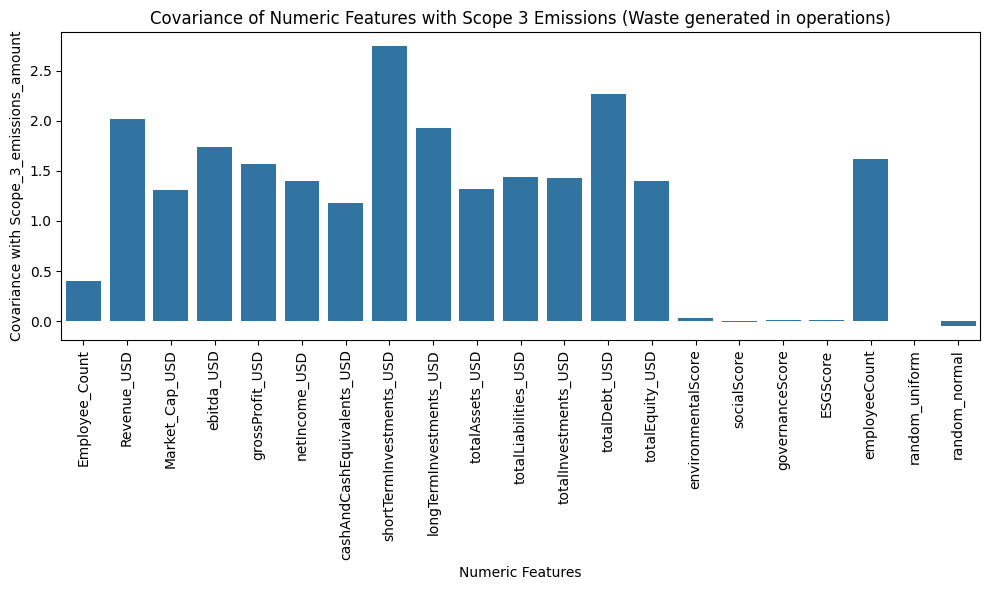

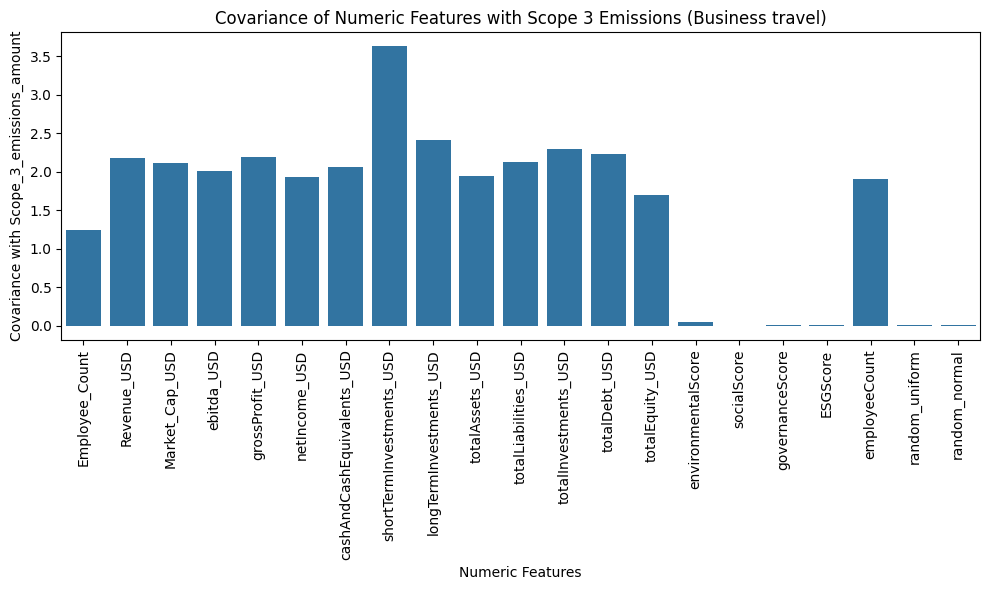

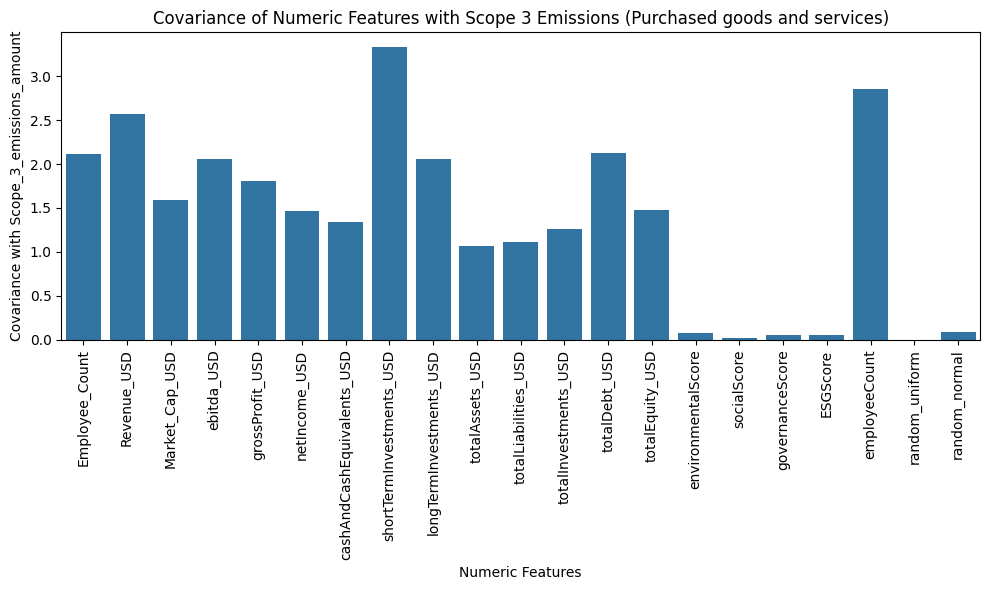

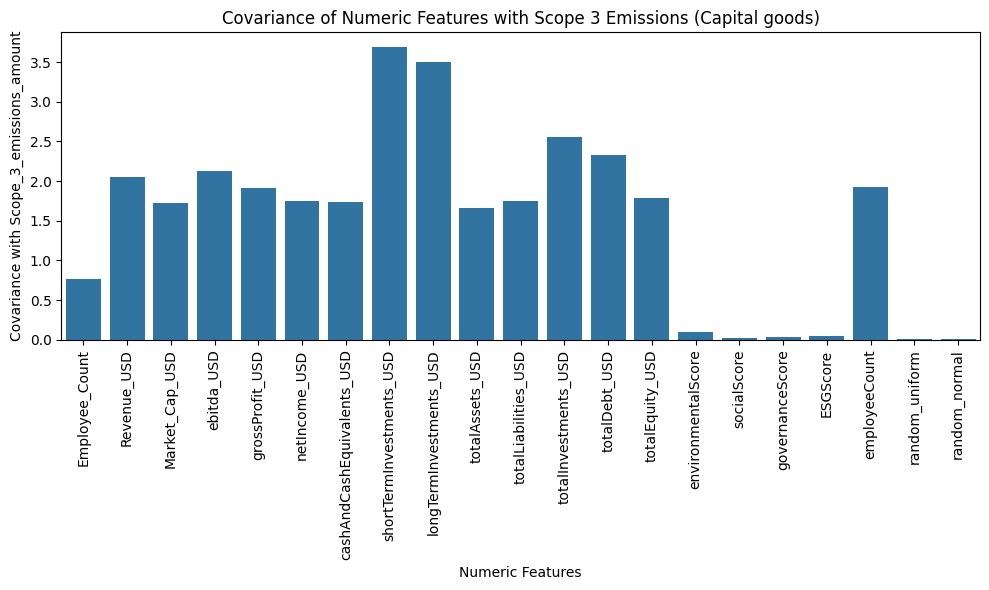

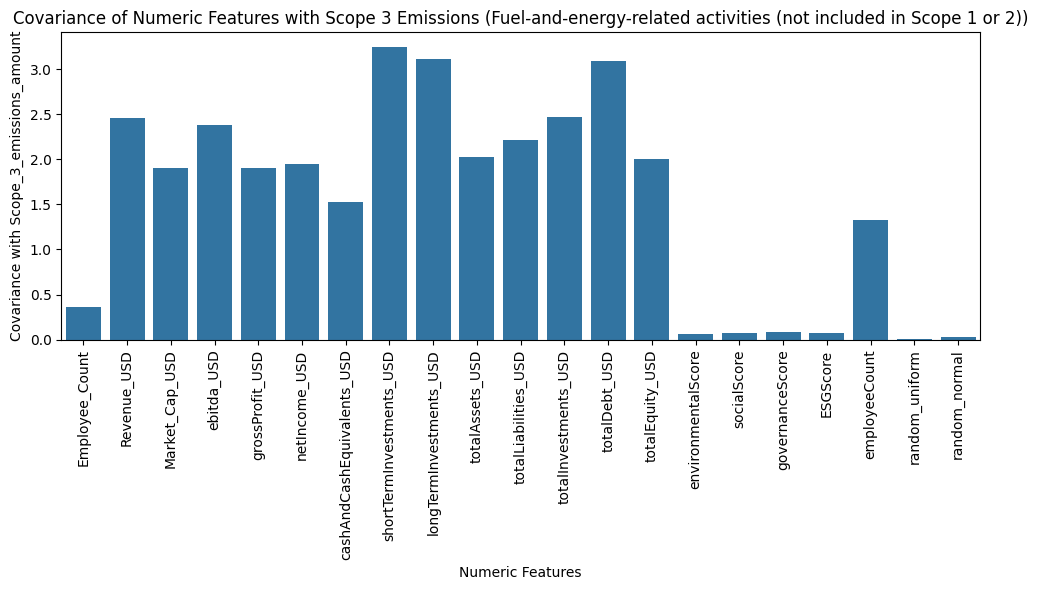

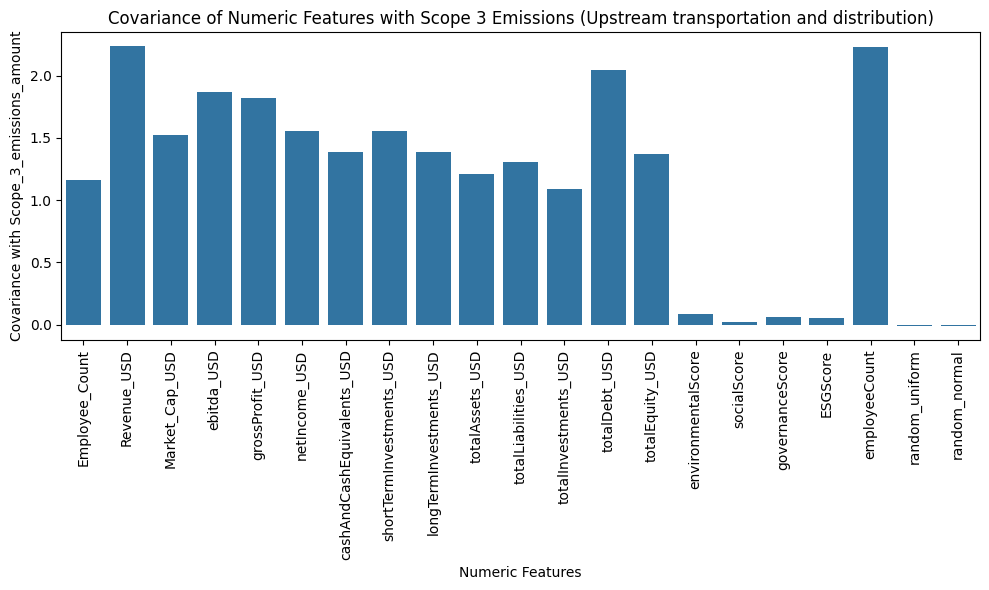

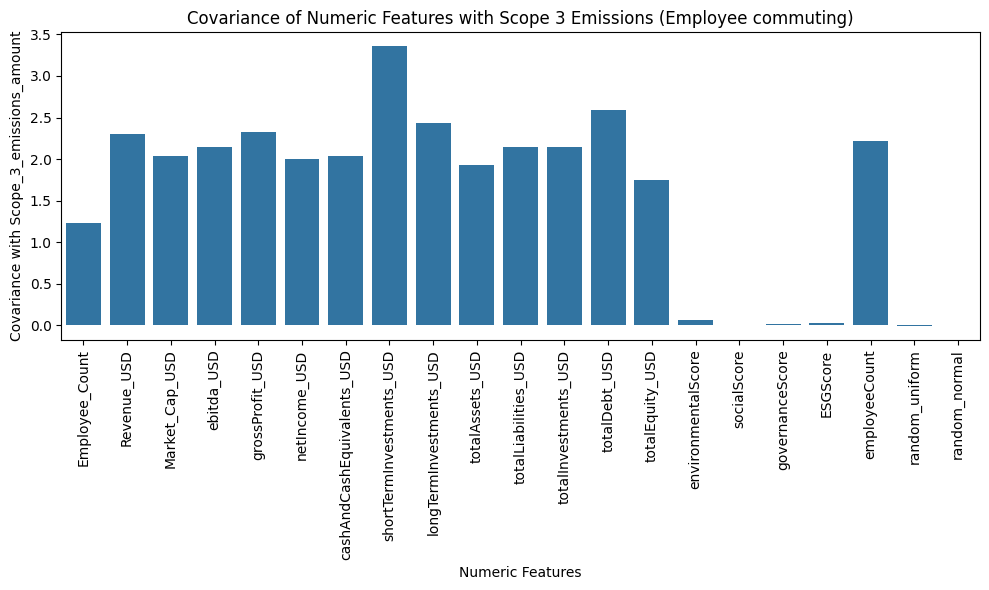

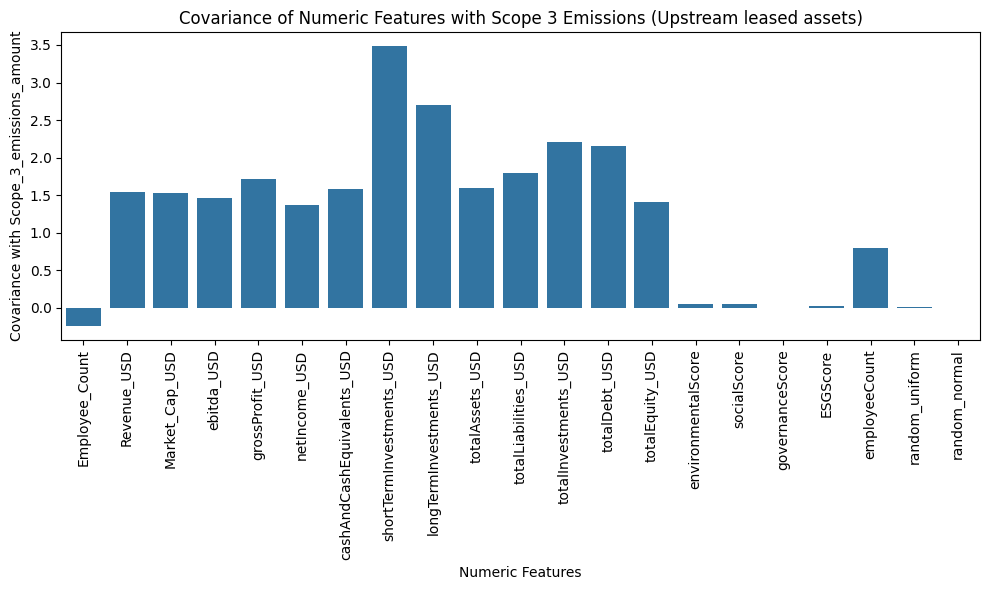

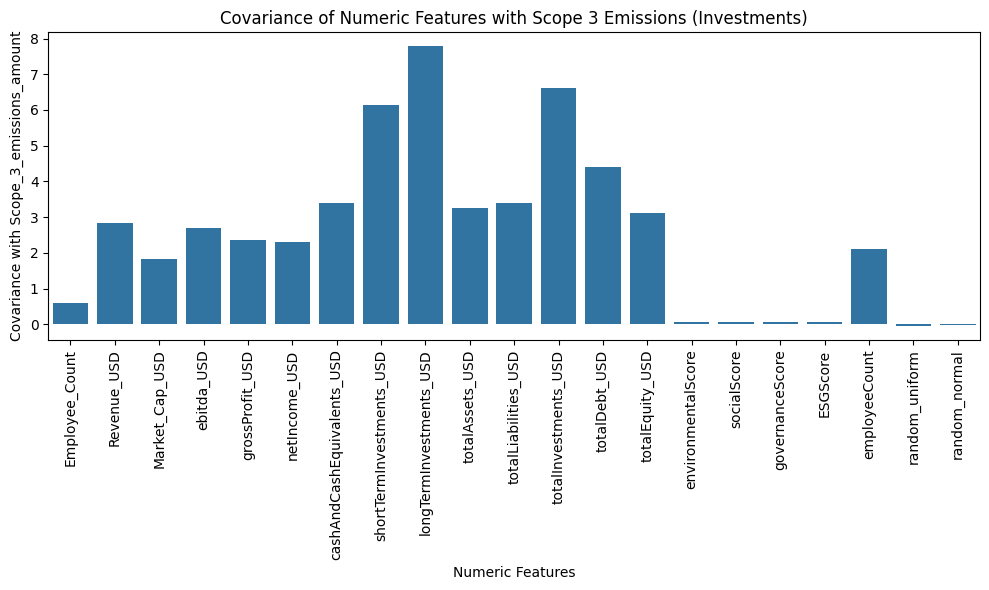

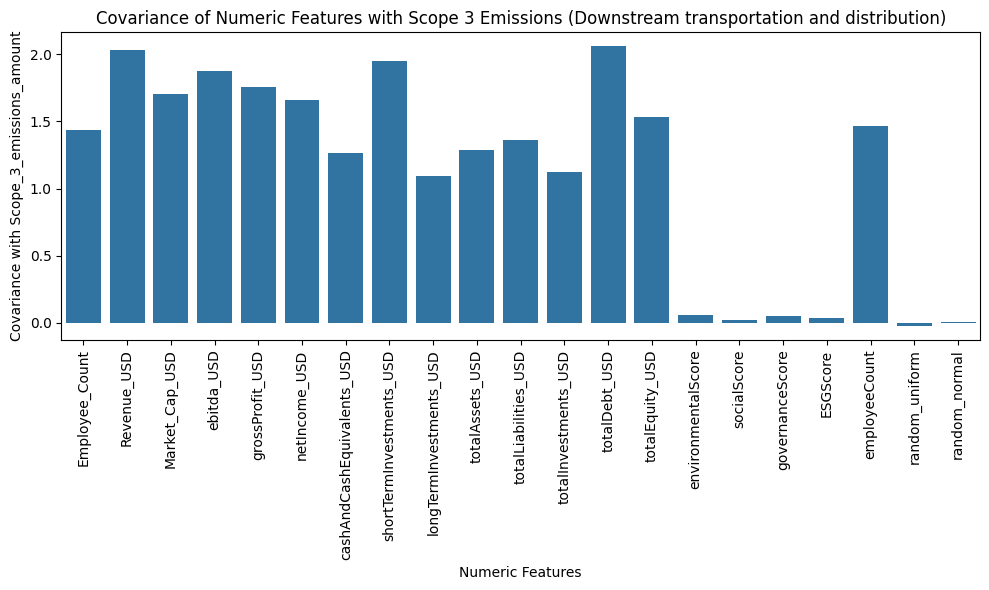

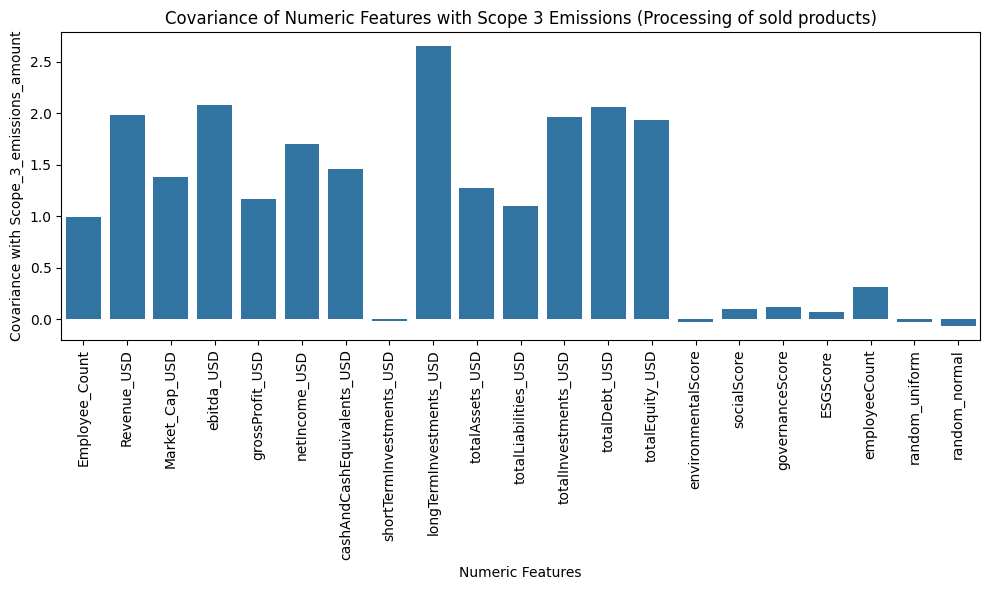

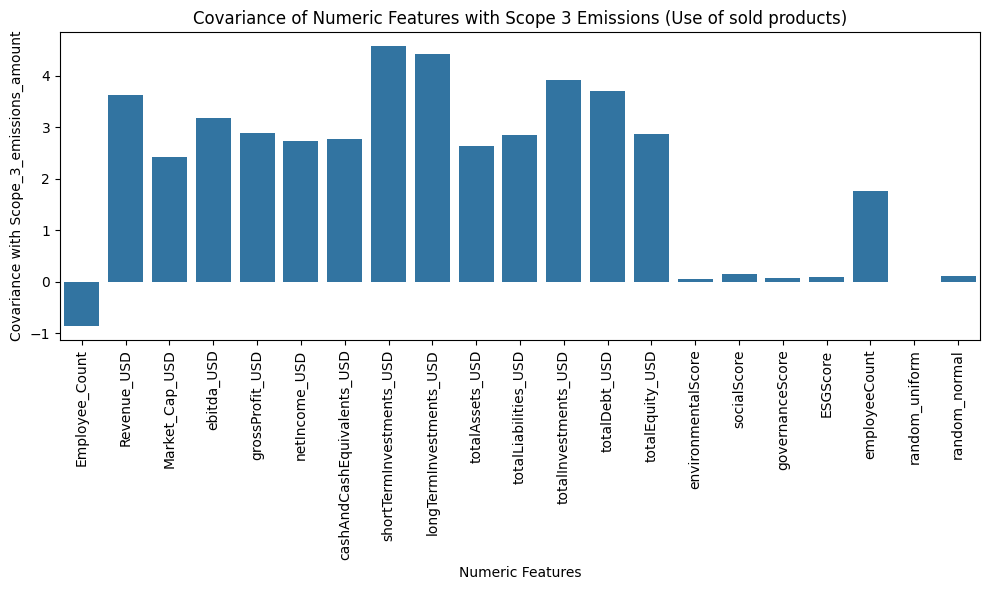

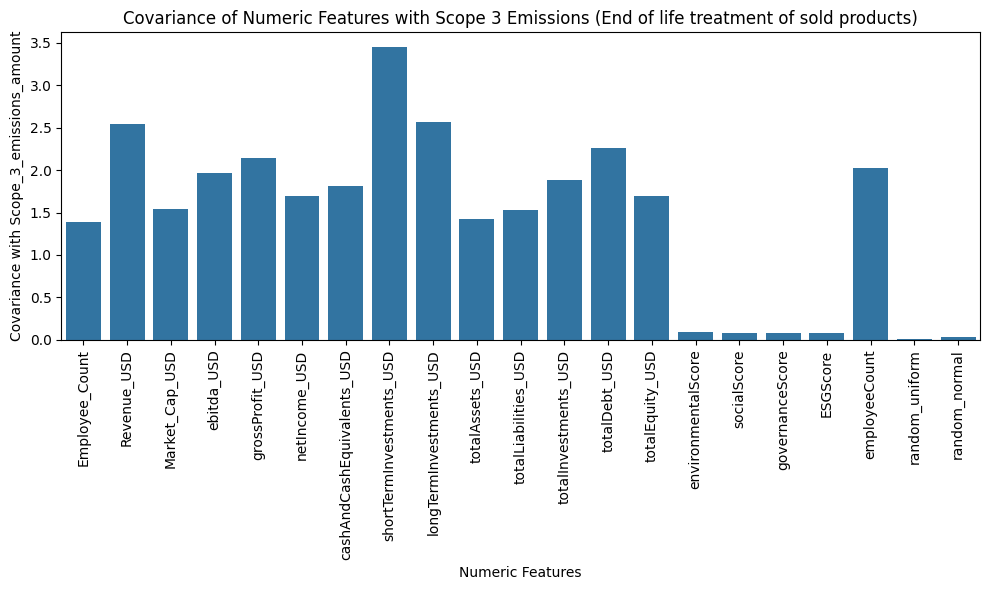

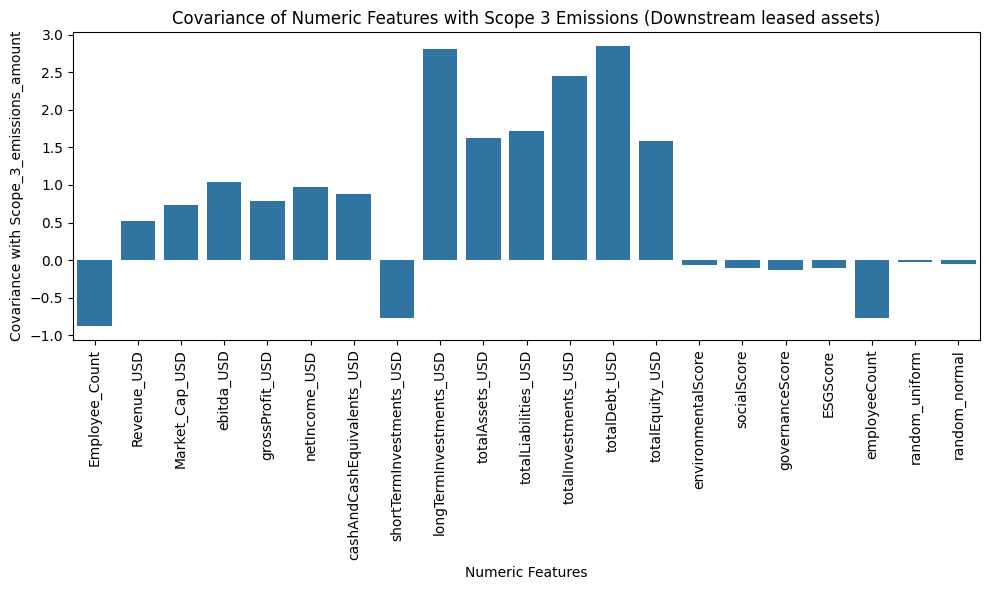

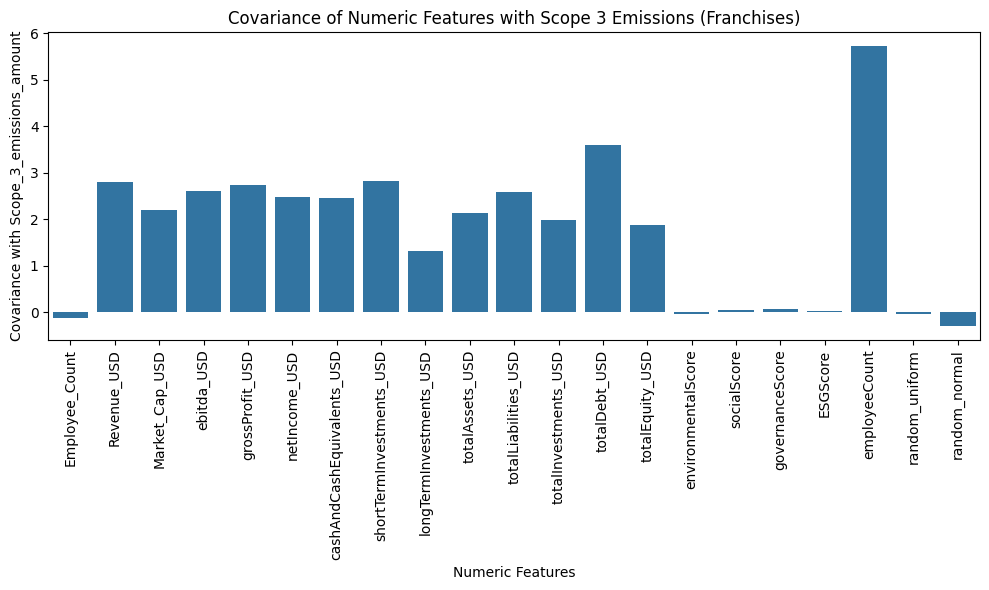

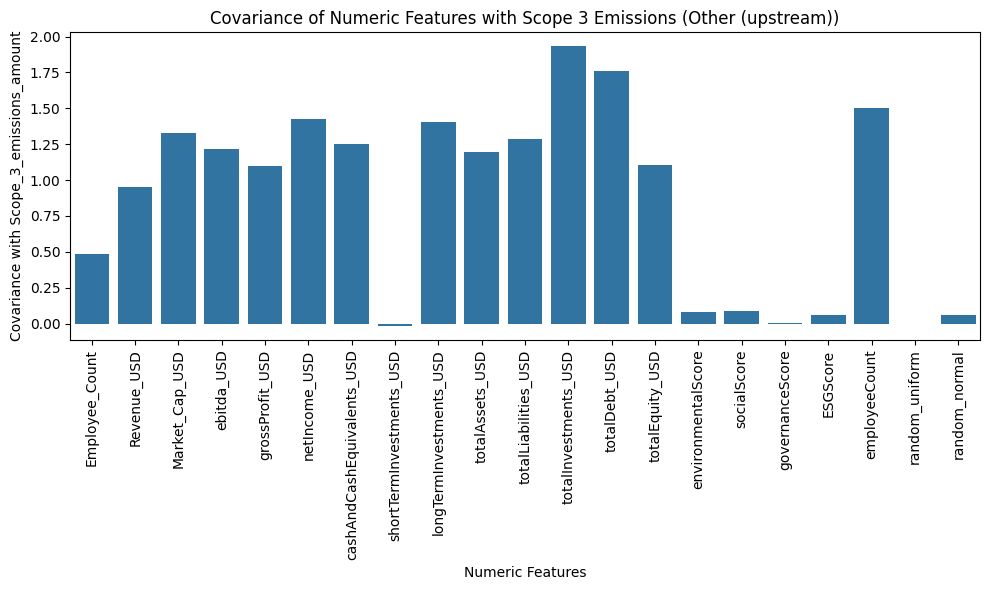

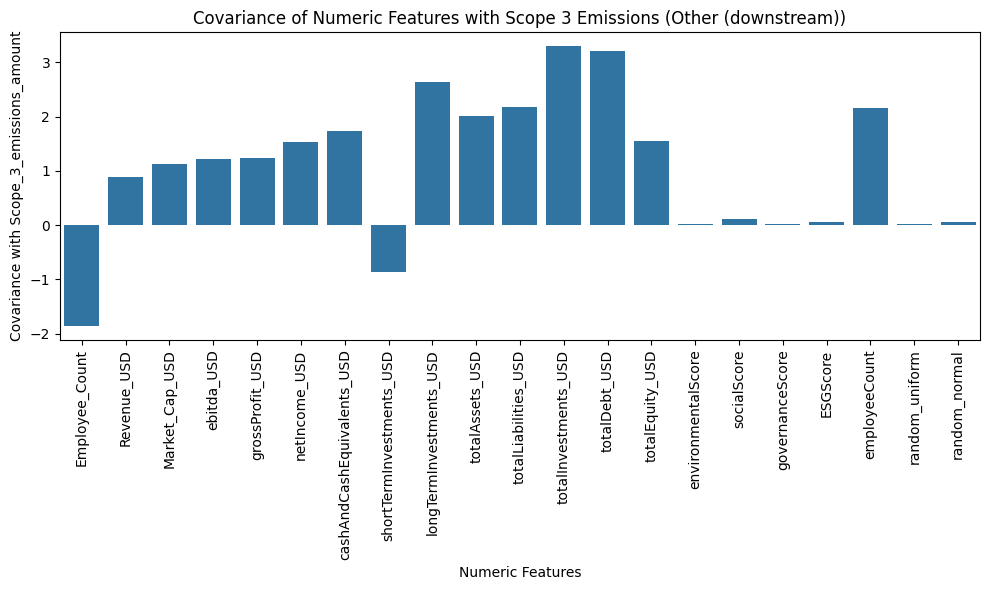

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_covariance_by_emission_type(df):
  """Calculates and plots covariance for numeric features with 'Scope_3_emissions_amount' for each 'Scope_3_emissions_type'."""

  for emission_type in df_cov['Scope_3_emissions_type'].unique():
      filtered_df = df_cov[df_cov['Scope_3_emissions_type'] == emission_type]
      numeric_features = filtered_df.select_dtypes(include=np.number).columns
      numeric_features = numeric_features.drop('Scope_3_emissions_amount', errors='ignore')

      if not numeric_features.empty and 'Scope_3_emissions_amount' in filtered_df.columns:
          target_variable = 'Scope_3_emissions_amount'
          covariance_matrix = filtered_df[numeric_features.tolist() + [target_variable]].cov()
          covariance_with_target = covariance_matrix[target_variable].drop(target_variable)

          plt.figure(figsize=(10, 6))
          sns.barplot(x=covariance_with_target.index, y=covariance_with_target.values)
          plt.xticks(rotation=90)
          plt.xlabel("Numeric Features")
          plt.ylabel("Covariance with Scope_3_emissions_amount")
          plt.title(f"Covariance of Numeric Features with Scope 3 Emissions ({emission_type})")
          plt.tight_layout()
          plt.show()
      else:
          print(f"No numeric features or 'Scope_3_emissions_amount' found for emission type: {emission_type}")

plot_covariance_by_emission_type(df)


In [ ]:
# Filter the DataFrame
filtered_df = df[df['Scope_3_emissions_type'] == 'Purchased goods and services']

# Calculate skewness and kurtosis for ESGScore and employeeCount in the filtered data
skewness_esg_filtered = filtered_df['ESGScore'].skew()
kurtosis_esg_filtered = filtered_df['ESGScore'].kurt()
skewness_employee_count_filtered = filtered_df['employeeCount'].skew()
kurtosis_employee_count_filtered = filtered_df['employeeCount'].kurt()

print(f"Skewness of ESG Score (PG&S): {skewness_esg_filtered}")
print(f"Kurtosis of ESG Score (PG&S): {kurtosis_esg_filtered}")
print(f"Skewness of Employee Count (PG&S): {skewness_employee_count_filtered}")
print(f"Kurtosis of Employee Count (PG&S): {kurtosis_employee_count_filtered}")

Skewness of ESG Score (PG&S): -2.091135525099543
Kurtosis of ESG Score (PG&S): 14.265251231508614
Skewness of Employee Count (PG&S): -2.018320445043638
Kurtosis of Employee Count (PG&S): 5.827385609697426


In [ ]:
filtered_df = df[df['Scope_3_emissions_type'] == 'Purchased goods and services']
filtered_df.describe()

,account_id,Scope_3_emissions_amount,Year,Market_Cap,Employee_Count,ebitda,Revenue,grossProfit,netIncome,cashAndCashEquivalents,...,totalInvestments_USD,totalDebt_USD,totalEquity_USD,environmentalScore,socialScore,governanceScore,ESGScore,employeeCount,random_uniform,random_normal
count,12097.000000,12097.000000,12097.000000,11723.000000,2300.000000,1.161300e+04,12097.000000,12005.000000,10721.000000,12081.000000,...,1.170500e+04,11902.000000,11703.000000,2424.000000,2424.000000,2424.000000,2424.000000,1842.000000,12097.000000,10233.000000
mean,9.578254,11.592956,7.611117,24.419155,7.697646,-inf,24.187036,23.093219,21.659272,22.235392,...,-inf,21.135639,21.985710,4.154789,4.163198,4.207761,4.179453,9.555967,0.384679,-0.032142
std,1.527563,4.058135,0.001481,2.518469,4.262726,NaN,2.725085,2.707758,2.664565,3.061912,...,NaN,3.217809,1.571633,0.200315,0.145087,0.121268,0.124614,2.431910,0.198430,0.935654
min,3.806662,0.000000,7.607878,4.183271,0.000000,-inf,10.227417,0.000000,0.000000,0.000000,...,-inf,0.000000,14.786928,0.246860,2.598235,3.059646,3.110399,0.000000,0.000047,-9.956899
25%,8.967632,9.512258,7.609862,22.652938,6.639545,2.058828e+01,22.269089,21.191939,19.823340,20.084607,...,1.780049e+01,20.122066,20.973231,4.064529,4.089332,4.145354,4.113820,8.853808,0.218635,-0.404421
50%,9.661352,12.689733,7.611348,24.158057,9.346138,2.208936e+01,23.720447,22.775079,21.413910,21.820544,...,1.972142e+01,21.619135,21.983002,4.172694,4.177459,4.214865,4.191017,9.833651,0.402748,0.188317
75%,10.039329,14.473031,7.612337,26.121675,10.621961,2.420250e+01,26.046905,24.880538,23.414577,24.528594,...,2.148175e+01,22.773018,23.056446,4.274302,4.253483,4.286582,4.256180,11.002117,0.560745,0.584524
max,13.742961,23.012731,7.612831,33.906868,14.648420,3.210932e+01,33.342214,32.360119,31.633433,32.363970,...,2.805556e+01,27.377001,26.640572,4.612741,4.602667,4.478132,4.545420,14.648420,0.693032,1.523682
